In [14]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from data_inputs import *
from plain_block import *
from baseline_block import *
from nafnet_block import *

plt.ion()

In [2]:
def view_img_sidebyside(img1, img2, size=(15, 15)):
    f, axarr = plt.subplots(1,2, figsize=size)
    axarr[0].imshow(img1)
    axarr[1].imshow(img2)
    plt.show()

In [10]:
def view_img_batches(img_batch, size=(10, 10)):
    f, axarr = plt.subplots(len(img_batch), 2, figsize=size)
    _, imgs = img_batch
    
    for i in range(len(imgs)):
        g_i, n_i = imgs['good_img'][i], imgs['noisy_img'][i]
        
        axarr[i, 0].imshow(g_i.numpy().transpose((1, 2, 0)))
        axarr[i, 1].imshow(n_i.numpy().transpose((1, 2, 0)))
    # set the spacing between subplots
    f.tight_layout()
    plt.show()

In [4]:
dataloader = SIDD_Dataset(img_dir='C:/Users/ddsdi/Desktop/Research Paper Implementations/Data/SIDD')

In [5]:
len(dataloader)

160

In [6]:
imgs = dataloader[0]

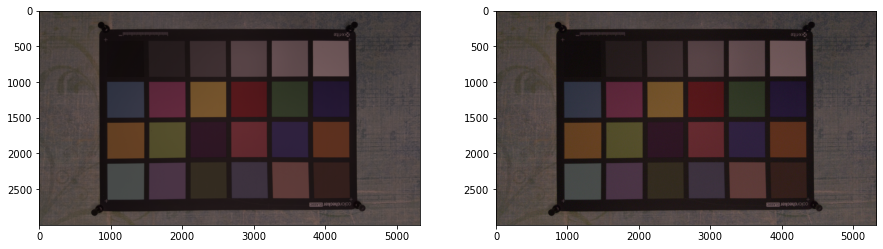

In [7]:
view_img_sidebyside(imgs['good_img'], imgs['noisy_img'])

In [12]:
transformed_dataset = SIDD_Dataset(img_dir='C:/Users/ddsdi/Desktop/Research Paper Implementations/Data/SIDD',
                                           transform=transforms.Compose([
                                                                Rescale((1000,1800)),
                                                                ToTensor()
                                                            ]))

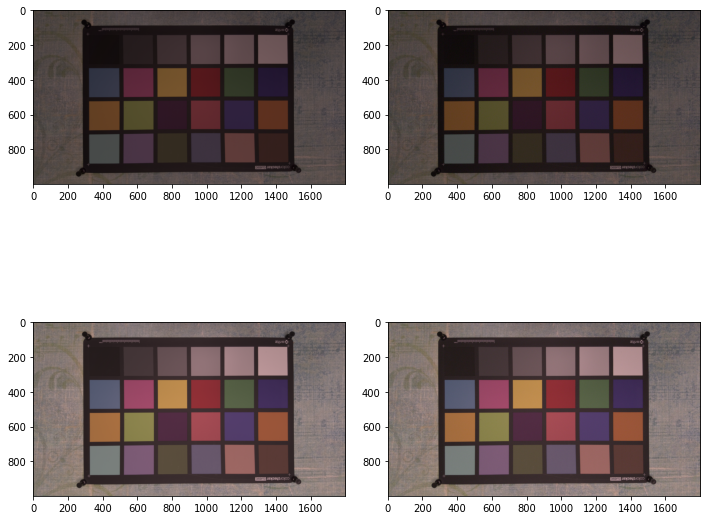

In [13]:
batched_dataset = DataLoader(transformed_dataset, batch_size=2)

view_img_batches(next(enumerate(batched_dataset)))

In the NAFnet paper they have trained the model with 256*256 images, which means they have processed images to smaller parts and then used that to train the model. But I have not done that in the below code. Therefore if we are to use original SIDD images here, it will not run.

Also NAFNet architecture is based on another paper named `HINet - Half Instance Normalization Network for Image Restoration`. And the below implementation is based on that.

In [1]:
import torch
from torch import nn
from nafnet_block import *
from plain_block import *
from baseline_block import *


class NAFNet(nn.Module):

    def __init__(self, num_filters=16, num_enc_components=2, num_mid_components=1, num_dec_components=2):
        super().__init__()

        self.encoder_blocks = nn.ModuleList()
        self.mid_blocks = nn.Sequential()
        self.decoder_blocks = nn.ModuleList()

        self.downsample_blocks = nn.ModuleList()
        self.upsample_blocks = nn.ModuleList()

        self.start_conv = nn.Conv2d(3, num_filters, kernel_size=3, stride=1, padding=1)
        self.end_conv = nn.Conv2d(num_filters, 3, kernel_size=3, stride=1, padding=1)

        temp_num_filters = num_filters
        for _ in range(num_enc_components):
           
            self.encoder_blocks.append(
                NAFNetBlock(temp_num_filters, temp_num_filters)
            )
            self.downsample_blocks.append(
                nn.Conv2d(temp_num_filters, temp_num_filters*2, kernel_size=2, stride=2)
            )
            temp_num_filters *= 2
            
        for _ in range(num_mid_components):
            self.mid_blocks.append(
                NAFNetBlock(temp_num_filters, temp_num_filters)
            )

        for _ in range(num_dec_components):

            self.upsample_blocks.append(
                nn.ConvTranspose2d(temp_num_filters, temp_num_filters//2, kernel_size=2, stride=2)
            )
            temp_num_filters = temp_num_filters//2
            
            self.decoder_blocks.append(
                NAFNetBlock(temp_num_filters, temp_num_filters)
            )


    def forward(self, input_data):
        
        start_conv = self.start_conv(input_data)

        encoding_data = start_conv
        
        skip_cons = []
        for naf_block, down_sampler in zip(self.encoder_blocks, self.downsample_blocks):
            encoding_data = naf_block(encoding_data)
            skip_cons.append(encoding_data)
            encoding_data = down_sampler(encoding_data)
            print(encoding_data.shape)

        encoding_data = self.mid_blocks(encoding_data)

        decoding_data = encoding_data
        for naf_block, up_sampler, skip_con in zip(self.decoder_blocks, self.upsample_blocks, skip_cons[::-1]):
            decoding_data = up_sampler(decoding_data)
            decoding_data = decoding_data + skip_con
            decoding_data = naf_block(decoding_data)
            print(decoding_data.shape)

        decoding_data = self.end_conv(decoding_data)
        output_data = decoding_data + input_data

        return output_data

In [2]:
from torch import nn
import torch
from data_inputs import *
from imageio.v2 import imread
import numpy as np

img = np.random.random((256,256,3))
img = img.transpose((2, 0, 1))
img = torch.from_numpy(img)

data = torch.unsqueeze(img, dim=0).type(torch.float)
data = nn.functional.normalize(data)
device = torch.device('cuda')

net = NAFNet()
net = net.to(torch.device(device))

data = data.to(device)

torch.Size([1, 32, 128, 128])
torch.Size([1, 64, 64, 64])
torch.Size([1, 32, 128, 128])
torch.Size([1, 16, 256, 256])


torch.Size([1, 3, 256, 256])